In [575]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler 

In [576]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [577]:
def load():
    data = pd.read_csv("Telco-Customer-Churn.csv")
    return data

In [578]:
# Adım 1: Genel resmi inceleyiniz.
df = load()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [579]:
df.shape

(7043, 21)

In [580]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [581]:
df.columns = [col.upper() for col in df.columns] # buyuk harfe cevirme

In [582]:
# Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [583]:
cat_cols, num_cols, cat_but_car, num_but_cat= grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [584]:
cat_cols

['GENDER',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'CHURN',
 'SENIORCITIZEN']

In [585]:
num_cols

['TENURE', 'MONTHLYCHARGES']

In [586]:
cat_but_car

['CUSTOMERID', 'TOTALCHARGES']

In [587]:
num_but_cat

['SENIORCITIZEN']

In [588]:
cat_but_car = [col for col in cat_but_car if col not in "CUSTOMERID"]

In [589]:
df["TOTALCHARGES"] = pd.to_numeric(df["TOTALCHARGES"], errors="coerce")  

In [590]:
num_cols= num_cols + cat_but_car

In [591]:
df["TOTALCHARGES"].dtypes

dtype('float64')

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: TENURE, dtype: float64


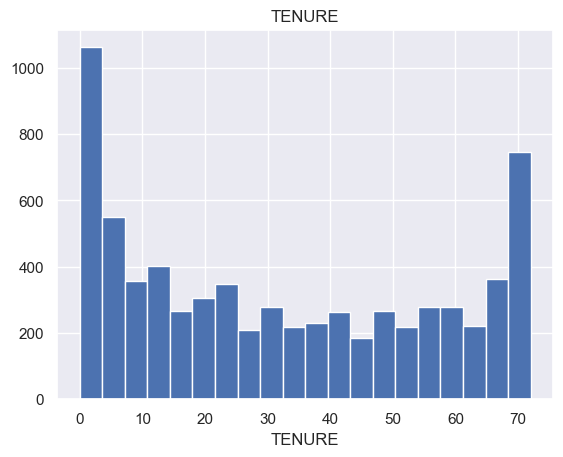

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MONTHLYCHARGES, dtype: float64


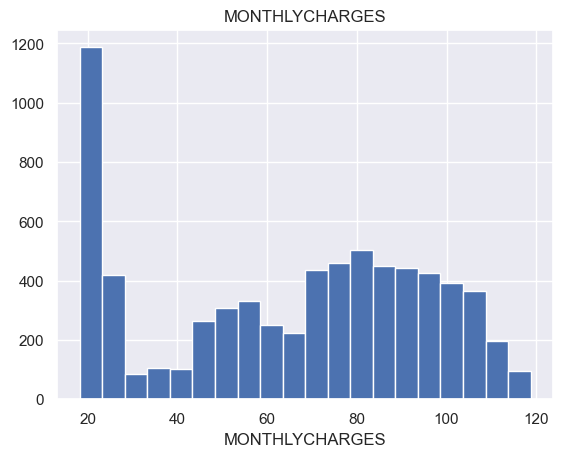

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TOTALCHARGES, dtype: float64


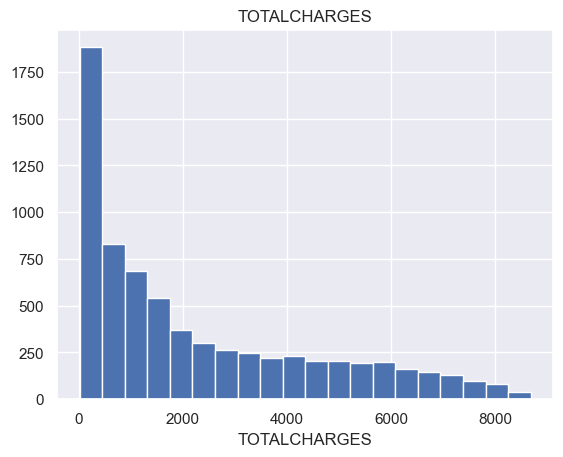

In [592]:
# Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız.
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [593]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("****************************************")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe) #gorsellestirmek istiyorsak yukarıdaki "plot=False"u True yaparız
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

        GENDER  Ratio
GENDER               
Male      3555 50.476
Female    3488 49.524
****************************************
         PARTNER  Ratio
PARTNER                
No          3641 51.697
Yes         3402 48.303
****************************************
            DEPENDENTS  Ratio
DEPENDENTS                   
No                4933 70.041
Yes               2110 29.959
****************************************
              PHONESERVICE  Ratio
PHONESERVICE                     
Yes                   6361 90.317
No                     682  9.683
****************************************
                  MULTIPLELINES  Ratio
MULTIPLELINES                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
****************************************
                 INTERNETSERVICE  Ratio
INTERNETSERVICE                        
Fiber optic                 3096 43.959
DSL                         2421 34.375


In [594]:
#Adım 4: Hedef değişken analizi yapınız.

In [595]:
df["CHURN"].head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: CHURN, dtype: object

In [596]:
df.loc[df["CHURN"]=="Yes", "CHURN"] = 1
df.loc[df["CHURN"]=="No", "CHURN"] = 0

In [597]:
df["CHURN"].head()

0    0
1    0
2    1
3    0
4    1
Name: CHURN, dtype: object

In [598]:
cat_cols
cat_cols= [col for col in cat_cols if col not in "CHURN"]

In [599]:
def target_summary_with_cat(dataframe, target, cat_cols):
    print(cat_cols)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(cat_cols)[target].mean(),
                        "Count": dataframe[cat_cols].value_counts(),
                        "Ratio": 100 * dataframe[cat_cols].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "CHURN", col)

GENDER
       TARGET_MEAN  Count  Ratio
GENDER                          
Female       0.269   3488 49.524
Male         0.262   3555 50.476


PARTNER
        TARGET_MEAN  Count  Ratio
PARTNER                          
No            0.330   3641 51.697
Yes           0.197   3402 48.303


DEPENDENTS
           TARGET_MEAN  Count  Ratio
DEPENDENTS                          
No               0.313   4933 70.041
Yes              0.155   2110 29.959


PHONESERVICE
             TARGET_MEAN  Count  Ratio
PHONESERVICE                          
No                 0.249    682  9.683
Yes                0.267   6361 90.317


MULTIPLELINES
                 TARGET_MEAN  Count  Ratio
MULTIPLELINES                             
No                     0.250   3390 48.133
No phone service       0.249    682  9.683
Yes                    0.286   2971 42.184


INTERNETSERVICE
                TARGET_MEAN  Count  Ratio
INTERNETSERVICE                          
DSL                   0.190   2421 34.375
Fiber op

In [600]:
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

In [601]:
def target_summary_with_num(dataframe, target, num_cols):
    print(dataframe.groupby(target).agg({num_cols: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "CHURN", col)

       TENURE
CHURN        
0      37.570
1      17.979


       MONTHLYCHARGES
CHURN                
0              61.265
1              74.441


       TOTALCHARGES
CHURN              
0          2555.344
1          1531.796




In [602]:
# Adım 5: Aykırı gözlem analizi yapınız.
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75): #q1 ve q3ü 5e 95 ya da 1e 99 da alabilirsin
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [603]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)  #q1 ve q3 ü burada yazarsak farklı deger icin,yukarıda col_name'in yanına da eklememiz lazım
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [604]:
for col in num_cols:
    print(col, check_outlier(df, col))

TENURE False
MONTHLYCHARGES False
TOTALCHARGES False


In [605]:
#Adım 6: Eksik gözlem analizi yapınız.
df.isnull().values.any()

True

In [606]:
df.isnull().sum()

CUSTOMERID           0
GENDER               0
SENIORCITIZEN        0
PARTNER              0
DEPENDENTS           0
TENURE               0
PHONESERVICE         0
MULTIPLELINES        0
INTERNETSERVICE      0
ONLINESECURITY       0
ONLINEBACKUP         0
DEVICEPROTECTION     0
TECHSUPPORT          0
STREAMINGTV          0
STREAMINGMOVIES      0
CONTRACT             0
PAPERLESSBILLING     0
PAYMENTMETHOD        0
MONTHLYCHARGES       0
TOTALCHARGES        11
CHURN                0
dtype: int64

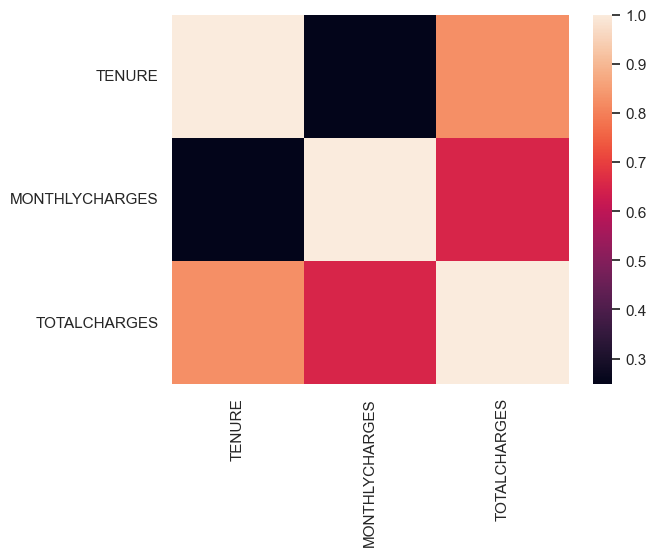

In [607]:
#Adım 7: Korelasyon analizi yapınız.
df[num_cols].corr()
sns.heatmap(df[num_cols].corr())
plt.show()

In [608]:
#*************FEATURE ENGINEERING*************#

In [609]:
#Adım 1: Eksik ve aykırı gözlemler için gerekli işlemleri yapınız.
dff= load()
dff.columns = [col.upper() for col in dff.columns]
dff[dff.isnull().any(axis=1)]

df[df.isnull().any(axis=1)]

df["TOTALCHARGES"].fillna(0, inplace=True) # eksik degerler 0'la dolduruldu

In [610]:
# Adım 2: Yeni değişkenler oluşturunuz.

In [611]:
df.loc[(df["TENURE"]>=0) & (df["TENURE"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["TENURE"]>12) & (df["TENURE"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["TENURE"]>24) & (df["TENURE"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["TENURE"]>36) & (df["TENURE"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["TENURE"]>48) & (df["TENURE"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["TENURE"]>60) & (df["TENURE"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [612]:
# herhangi bir streaming hizmeti alan kisiler
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["STREAMINGTV"] == "Yes") or (x["STREAMINGMOVIES"] == "Yes") else 0, axis=1)

In [613]:
# toplam alinan servis sayisi
df["NEW_TOTALSERVICE"] = (df[["PHONESERVICE", "INTERNETSERVICE", "ONLINESECURITY",
                                       "ONLINEBACKUP", "DEVICEPROTECTION", "TECHSUPPORT",
                                       "STREAMINGTV", "STREAMINGMOVIES"]]== "Yes").sum(axis=1)

In [614]:
# servis basina ucret
df["NEW_AVG_SERVICE_FEE"] = df["MONTHLYCHARGES"] / (df["NEW_TOTALSERVICE"] + 1)

In [615]:
# kontrati 1 - 2 yil olan musterileri birlestirme
df["NEW_CONTRACT"] = df["CONTRACT"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)


In [616]:
# genc olan ve aylik sozlesmesi olanlar
df["NEW_YOUNG_MONTH_TO_MONTH"] = df.apply(lambda x: 1 if (x["NEW_CONTRACT"] == 0) and (x["SENIORCITIZEN"] == 0) else 0, axis=1)


In [617]:
# otomatik odeme
df["NEW_FLAG_AUTO_PAYMENT"] = df["PAYMENTMETHOD"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [618]:
# ortalama aylik odeme
df["NEW_AVG_CHARGES"] = df["TOTALCHARGES"] / (df["TENURE"] + 1)

In [619]:
# Guncel fiyatin ortalama fiyata gore artisi
df["NEW_INCREASE"] = df["NEW_AVG_CHARGES"] / df["MONTHLYCHARGES"]

In [620]:
# Herhangi bir destek, yedek veya koruma alan kisiler
df["NEW_BACKUP_PROTECTION_SUPPORT"] = df.apply(lambda x: 1 if (x["ONLINEBACKUP"] == "Yes") or (x["DEVICEPROTECTION"] == "Yes") or (x["TECHSUPPORT"] == "Yes") else 0, axis=1)

In [621]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CUSTOMERID                     7043 non-null   object 
 1   GENDER                         7043 non-null   object 
 2   SENIORCITIZEN                  7043 non-null   int64  
 3   PARTNER                        7043 non-null   object 
 4   DEPENDENTS                     7043 non-null   object 
 5   TENURE                         7043 non-null   int64  
 6   PHONESERVICE                   7043 non-null   object 
 7   MULTIPLELINES                  7043 non-null   object 
 8   INTERNETSERVICE                7043 non-null   object 
 9   ONLINESECURITY                 7043 non-null   object 
 10  ONLINEBACKUP                   7043 non-null   object 
 11  DEVICEPROTECTION               7043 non-null   object 
 12  TECHSUPPORT                    7043 non-null   o

In [622]:
#Adım 3: Encoding işlemlerini gerçekleştiriniz.
cat_cols, num_cols, cat_but_car, num_but_cat= grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 7


In [623]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"] #int yada float olmayan ve essiz iki sınıfa sahip olan degiskenleri sec
               and df[col].nunique() == 2]
for col in binary_cols:
    dff = label_encoder(df, col)

In [624]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in dff.columns if 10 >= dff[col].nunique() > 2]

dff= one_hot_encoder(dff, ohe_cols)

In [625]:
cat_cols

['GENDER',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'CHURN',
 'NEW_TENURE_YEAR',
 'SENIORCITIZEN',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_TOTALSERVICE',
 'NEW_CONTRACT',
 'NEW_YOUNG_MONTH_TO_MONTH',
 'NEW_FLAG_AUTO_PAYMENT',
 'NEW_BACKUP_PROTECTION_SUPPORT']

In [626]:
#Adım 4: Numerik değişkenler için standartlaştırma yapınız.
cat_cols, num_cols, cat_but_car, num_but_cat= grab_col_names(dff)
num_cols

Observations: 7043
Variables: 52
cat_cols: 45
num_cols: 6
cat_but_car: 1
num_but_cat: 45


['TENURE',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'NEW_AVG_SERVICE_FEE',
 'NEW_AVG_CHARGES',
 'NEW_INCREASE']

In [627]:
mms = MinMaxScaler()
dff["TENURE_MinMax_Scaler"] = mms.fit_transform(dff[["TENURE"]])
dff.describe().T

,count,mean,std,min,25%,50%,75%,max
GENDER,7043.000,0.505,0.500,0.000,0.000,1.000,1.000,1.000
SENIORCITIZEN,7043.000,0.162,0.369,0.000,0.000,0.000,0.000,1.000
PARTNER,7043.000,0.483,0.500,0.000,0.000,0.000,1.000,1.000
DEPENDENTS,7043.000,0.300,0.458,0.000,0.000,0.000,1.000,1.000
TENURE,7043.000,32.371,24.559,0.000,9.000,29.000,55.000,72.000
PHONESERVICE,7043.000,0.903,0.296,0.000,1.000,1.000,1.000,1.000
PAPERLESSBILLING,7043.000,0.592,0.491,0.000,0.000,1.000,1.000,1.000
MONTHLYCHARGES,7043.000,64.762,30.090,18.250,35.500,70.350,89.850,118.750
TOTALCHARGES,7043.000,2279.734,2266.794,0.000,398.550,1394.550,3786.600,8684.800
CHURN,7043.000,0.265,0.442,0.000,0.000,0.000,1.000,1.000


In [628]:
mms = MinMaxScaler()
dff["MONTHLYCHARGES_MinMax_Scaler"] = mms.fit_transform(dff[["MONTHLYCHARGES"]])

In [629]:
mms = MinMaxScaler()
dff["TOTALCHARGES_MinMax_Scaler"] = mms.fit_transform(dff[["TOTALCHARGES"]])

In [630]:
mms = MinMaxScaler()
dff["NEW_AVG_CHARGES_MinMax_Scaler"] = mms.fit_transform(dff[["NEW_AVG_CHARGES"]])

In [631]:
mms = MinMaxScaler()
dff["NEW_INCREASE_CHARGES_MinMax_Scaler"] = mms.fit_transform(dff[["NEW_INCREASE"]])

In [632]:
mms = MinMaxScaler()
dff["NEW_AVG_SERVICE_FEE_CHARGES_MinMax_Scaler"] = mms.fit_transform(dff[["NEW_AVG_SERVICE_FEE"]])

In [633]:
#Adım 5: Model oluşturunuz.
y = dff["CHURN"] #bagımlı degisken
X = dff.drop(["CUSTOMERID", "CHURN"], axis=1) 

In [634]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [635]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train) 
y_pred = rf_model.predict(X_test) 
accuracy_score(y_pred, y_test) 

0.7851396119261713

In [636]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


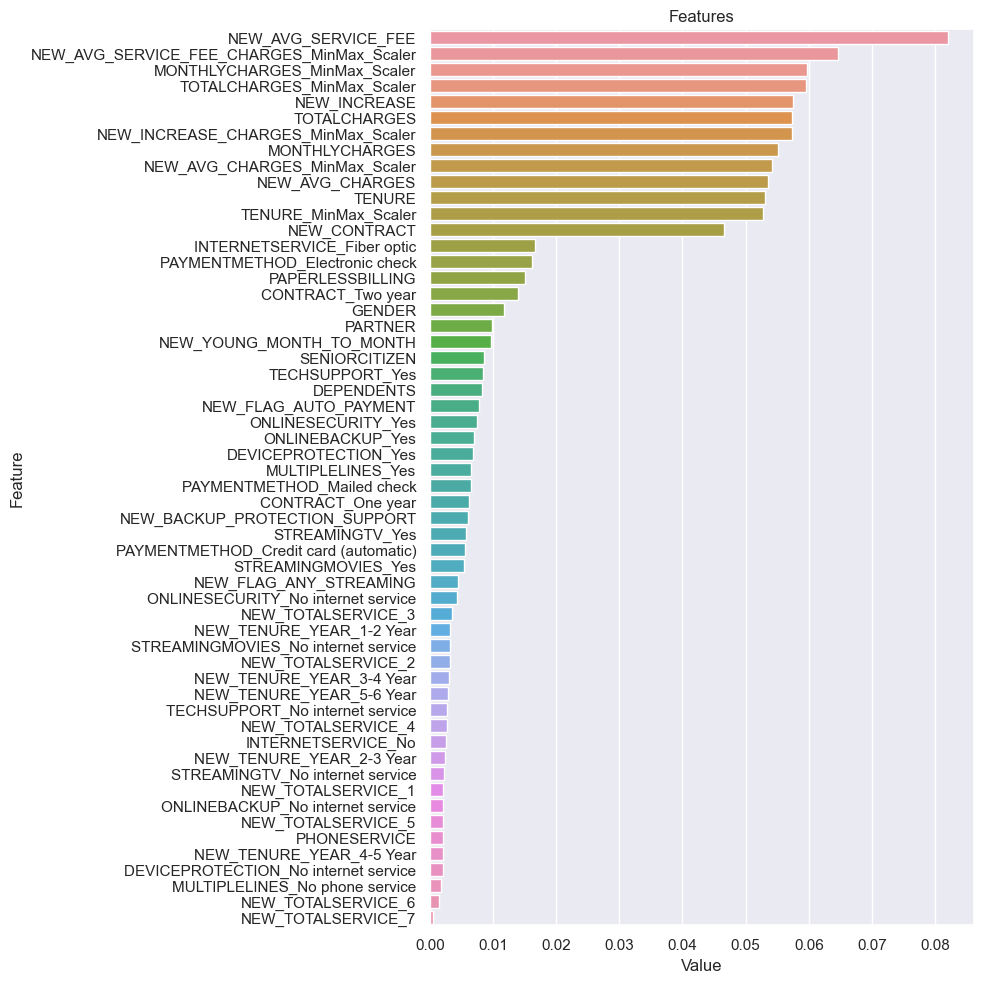

In [637]:
plot_importance(rf_model, X_train)